# Step 1:- Scraping data from website

## Importing Libraries

In [180]:
import requests #Allows you to send HTTP request using python
from requests import get #This is used to get the content from the URL
from bs4 import BeautifulSoup #A python library used to parse HTML and XML documents
import pandas as pd #For data manipulation and analysis
import numpy as np #For mathematical calculations and to create multidimentional array if required
from time import sleep #To pause the execution for a specific amount of time
from random import randint #For varing the amount of waiting time
import matplotlib.pyplot as plt # for plotting graphs 
import seaborn as sns # for plotting graphs

## Setting preferred language (relative quality factor)

Here, 'q' in the below line defines the relative quality factor. It specifies what language the user would prefer, on a scale of 0 to 1 where 0 is the lowest and 1 is the highest. In our condition, q=0.5 defines that we prefer US English as MIME type for our purpose.

In [2]:
headers = {"Accept-Language": "en-US,en;q=0.5"}

## Initializing empty lists to store scraped data

In [3]:
movie_Name = []
year = []
duration = []

imdb_Ratings = []
metascore = []
votes = []
gross = []

## Changing the URL parameter

If you study thr URL parameter by clicking onto the next page, you'll notice that only "start" parameter is changing in the URL extension with an difference of 50. This is due to the fact that in this series of html pages, only 50 movie details are provided in each page.

For this purpose we will use the code block below to create a list of numbers which will be used not only as the base for looping but also to update the URL for next page. 

In [4]:
pages = np.arange(1, 1001, 50)
#print(pages)

## Iteration and Extraction

Now we are using for loop for the following

1. To iterate through each html page
2. To parse each html page using BeautifulSoup
3. Extracting the division of each html page in which we are interested (data of interest)
4. Extracting the data from each division under different class name

In [5]:
for page in pages: 

  page = requests.get("https://www.imdb.com/search/title/?groups=top_1000&start=" + str(page) + "&ref_=adv_nxt", headers=headers)

  soup = BeautifulSoup(page.text, 'html.parser')
  movie_div = soup.find_all('div', class_='lister-item mode-advanced')
  
  sleep(randint(2,10))

  for container in movie_div:

        name = container.h3.a.text
        movie_Name.append(name)
        
        release = container.h3.find('span', class_='lister-item-year').text
        year.append(release)

        time = container.p.find('span', class_='runtime') if container.p.find('span', class_='runtime') else ''
        duration.append(time)

        imdb = float(container.strong.text)
        imdb_Ratings.append(imdb)

        m_score = container.find('span', class_='metascore').text if container.find('span', class_='metascore') else ''
        metascore.append(m_score)

        nv = container.find_all('span', attrs={'name': 'nv'})
        
        vote = nv[0].text
        votes.append(vote)
        
        gross_sale = nv[1].text if len(nv) > 1 else ''
        gross.append(gross_sale)

## Data Wrangling

Finally creating a DataFrame (movies) which will contain all the data in the dictionary format

In [6]:
movies = pd.DataFrame({
'movie': movie_Name,
'year': year,
'imdb': imdb_Ratings,
'metascore': metascore,
'votes': votes,
'grossMillions': gross,
'timeMin': duration
})
#print(movies)

## Data Formatting

Data formatting is needed for the following

1. To remove inaccurate or corrupt data
2. To emphasize the crucial data
3. To remove data inconsistancy

In [7]:
movies['votes'] = movies['votes'].str.replace(',', '').astype(int)

movies.loc[:, 'year'] = movies['year'].str[-5:-1].astype(int)

movies['timeMin'] = movies['timeMin'].astype(str)
movies['timeMin'] = movies['timeMin'].str.extract('(\d+)').astype(int)

movies['metascore'] = movies['metascore'].str.extract('(\d+)')
movies['metascore'] = pd.to_numeric(movies['metascore'], errors='coerce')

movies['grossMillions'] = movies['grossMillions'].map(lambda x: x.lstrip('$').rstrip('M'))
movies['grossMillions'] = pd.to_numeric(movies['grossMillions'], errors='coerce')

After data formatting

In [8]:
# To see your dataframe
print(movies)

# To see the datatypes of your columns
print(movies.dtypes)


                                                 movie  year  imdb  metascore  \
0                                           Knives Out  2019   7.9       82.0   
1                                       Ford v Ferrari  2019   8.1       81.0   
2                     Once Upon a Time... in Hollywood  2019   7.7       83.0   
3                                             Parasite  2019   8.6       96.0   
4                                                Joker  2019   8.5       59.0   
5                                        The Gentlemen  2019   7.9       51.0   
6                                                 1917  2019   8.3       78.0   
7                                    Avengers: Endgame  2019   8.4       78.0   
8                                        Into the Wild  2007   8.1       73.0   
9                             The Shawshank Redemption  1994   9.3       80.0   
10                                           Inception  2010   8.8       74.0   
11                          

## Saving data to CSV file

In [11]:
# Saving the dataframe with dictionary to a CSV file
movies.to_csv('movies.csv')

# Step 2:- Exploratory Data Analysis (EDA)

**Q:- What is Exploratory Data Analysis (EDA)?**

A:- Exploratory Data Analysis commonly known as EDA is a means to understand the dataset by 
1. *Understanding the nature of the data* 
2. *Summerizing the main characteristics of the dataset* 
3. *Understanding the constants and variables of the dataset*

**Q:- How to perform Exploratory Data Analysis?**

A:- There are no specific methodology to perform EDA, this is entirely depend on the dataset we are working with.

**Q:- How do we perfrom EDA with our scraped IMDB dataset?**

A:- We will perform EDA with the following steps
1. *We will try to find out the data inconsistancy/missing values*
2. *How to resolve those missing values*
3. *Plotting graphs on the basis of the subsequent data (part of statistical analysis)*

To find out the no. of missing values

In [9]:
print(movies.isnull().sum())

movie              0
year               0
imdb               0
metascore        160
votes              0
grossMillions    160
timeMin            0
dtype: int64


As we have find out that there are 160 missing values(NANs) in metascore and 160 in gross value.
So now the question comes:-  What we can do with it?

Well, we have 2 options
1. Fill the missing values which involves replacing NAN either with a default value or replacing it with most suitable value for analysis i.e mean or median (I prefer median)
2. Remove the missing values by row or by column

In [13]:
#Replacing missing values with default ones
moviesv1 = movies.copy()
moviesv1.metascore = moviesv1.metascore.fillna("No Metascore") #Replacing 'NAN' with 'No Metascore'
moviesv1.grossMillions = moviesv1.grossMillions.fillna("Nil") #Replacing 'NAN' with 'Nil'

print(moviesv1.metascore)
print(moviesv1.grossMillions)

0                82
1                81
2                83
3                96
4                59
5                51
6                78
7                78
8                73
9                80
10               74
11               58
12              100
13               92
14               87
15               91
16               74
17               84
18               56
19               64
20               85
21               75
22               93
23               74
24               87
25               89
26               62
27               73
28               68
29               94
           ...     
970    No Metascore
971    No Metascore
972    No Metascore
973    No Metascore
974              80
975              51
976    No Metascore
977              80
978              89
979    No Metascore
980    No Metascore
981              79
982              96
983    No Metascore
984    No Metascore
985              81
986    No Metascore
987              75
988              62


Note:- If we will try to summerize the data for analysis, replacing missing values with default values is not preferable, even if we replace missing values with 0, it will lead to data inconsistancy in the future steps

That's why we prefer replacing missing values with mean or median

In [15]:
#Replacing values with mean of that column
moviesv2 = movies.copy()
moviesv2.metascore = moviesv2['metascore'].fillna(moviesv2['metascore'].mean())
moviesv2.grossMillions = moviesv2['grossMillions'].fillna(moviesv2['grossMillions'].mean())

print(moviesv2.metascore)
print(moviesv2.grossMillions)

0       82.000000
1       81.000000
2       83.000000
3       96.000000
4       59.000000
5       51.000000
6       78.000000
7       78.000000
8       73.000000
9       80.000000
10      74.000000
11      58.000000
12     100.000000
13      92.000000
14      87.000000
15      91.000000
16      74.000000
17      84.000000
18      56.000000
19      64.000000
20      85.000000
21      75.000000
22      93.000000
23      74.000000
24      87.000000
25      89.000000
26      62.000000
27      73.000000
28      68.000000
29      94.000000
          ...    
970     77.784524
971     77.784524
972     77.784524
973     77.784524
974     80.000000
975     51.000000
976     77.784524
977     80.000000
978     89.000000
979     77.784524
980     77.784524
981     79.000000
982     96.000000
983     77.784524
984     77.784524
985     81.000000
986     77.784524
987     75.000000
988     62.000000
989     85.000000
990     77.784524
991     77.784524
992     64.000000
993     70.000000
994     77

In [12]:
# Replacing values with median of that column
moviesv3 = movies.copy()
moviesv3.metascore = moviesv3['metascore'].fillna(moviesv3['metascore'].median())
moviesv3.grossMillions = moviesv3['grossMillions'].fillna(moviesv3['grossMillions'].median())

print(moviesv3.metascore)
print(moviesv3.grossMillions)

0       82.0
1       81.0
2       83.0
3       96.0
4       59.0
5       51.0
6       78.0
7       78.0
8       73.0
9       80.0
10      74.0
11      58.0
12     100.0
13      92.0
14      87.0
15      91.0
16      74.0
17      84.0
18      56.0
19      64.0
20      85.0
21      75.0
22      93.0
23      74.0
24      87.0
25      89.0
26      62.0
27      73.0
28      68.0
29      94.0
       ...  
970     79.0
971     79.0
972     79.0
973     79.0
974     80.0
975     51.0
976     79.0
977     80.0
978     89.0
979     79.0
980     79.0
981     79.0
982     96.0
983     79.0
984     79.0
985     81.0
986     79.0
987     75.0
988     62.0
989     85.0
990     79.0
991     79.0
992     64.0
993     70.0
994     79.0
995     73.0
996     79.0
997     79.0
998     79.0
999     79.0
Name: metascore, Length: 1000, dtype: float64
0      165.360
1      117.620
2      142.500
3       53.370
4      335.450
5       24.795
6      159.230
7      858.370
8       18.350
9       28.340
10     292.

Note:- 
1. The replacement of missing values with substitute value is known as Imputation 
2. V2 and V3 of movies dataframe can be used later for comparison via standard deviation and error bars

In [21]:
# Dropping all rows with any NAN values:
movies.dropna()

,movie,year,imdb,metascore,votes,grossMillions,timeMin
0,Knives Out,2019,7.9,82.0,337202,165.36,130
1,Ford v Ferrari,2019,8.1,81.0,229395,117.62,152
2,Once Upon a Time... in Hollywood,2019,7.7,83.0,485817,142.50,161
3,Parasite,2019,8.6,96.0,438957,53.37,132
4,Joker,2019,8.5,59.0,819427,335.45,122
6,1917,2019,8.3,78.0,336848,159.23,119
7,Avengers: Endgame,2019,8.4,78.0,734503,858.37,181
8,Into the Wild,2007,8.1,73.0,555708,18.35,148
9,The Shawshank Redemption,1994,9.3,80.0,2257069,28.34,142
10,Inception,2010,8.8,74.0,1979973,292.58,148


In [23]:
#Dropping any columns with NAN values

movies.dropna(axis=1, how='any') #axis=1 is for columns and axis=0 is for rows; how='any' is used to remove any NAN values

,movie,year,imdb,votes,timeMin
0,Knives Out,2019,7.9,337202,130
1,Ford v Ferrari,2019,8.1,229395,152
2,Once Upon a Time... in Hollywood,2019,7.7,485817,161
3,Parasite,2019,8.6,438957,132
4,Joker,2019,8.5,819427,122
5,The Gentlemen,2019,7.9,155101,113
6,1917,2019,8.3,336848,119
7,Avengers: Endgame,2019,8.4,734503,181
8,Into the Wild,2007,8.1,555708,148
9,The Shawshank Redemption,1994,9.3,2257069,142


In [35]:

movies.metascore = movies['metascore'].fillna(movies['metascore'].median())
movies.grossMillions = movies['grossMillions'].fillna(movies['grossMillions'].median())

movies

,movie,year,imdb,metascore,votes,grossMillions,timeMin
0,Knives Out,2019,7.9,82.0,337202,165.360,130
1,Ford v Ferrari,2019,8.1,81.0,229395,117.620,152
2,Once Upon a Time... in Hollywood,2019,7.7,83.0,485817,142.500,161
3,Parasite,2019,8.6,96.0,438957,53.370,132
4,Joker,2019,8.5,59.0,819427,335.450,122
5,The Gentlemen,2019,7.9,51.0,155101,24.795,113
6,1917,2019,8.3,78.0,336848,159.230,119
7,Avengers: Endgame,2019,8.4,78.0,734503,858.370,181
8,Into the Wild,2007,8.1,73.0,555708,18.350,148
9,The Shawshank Redemption,1994,9.3,80.0,2257069,28.340,142


In [221]:
#Saving the corrected dataset for future use
movies.to_csv('movies_final.csv')

Some Mandatory Checks

In [218]:
movies.head()

,movie,year,imdb,metascore,votes,grossMillions,timeMin
0,Knives Out,2019,7.9,82.0,337202,165.36,130
1,Ford v Ferrari,2019,8.1,81.0,229395,117.62,152
2,Once Upon a Time... in Hollywood,2019,7.7,83.0,485817,142.50,161
3,Parasite,2019,8.6,96.0,438957,53.37,132
4,Joker,2019,8.5,59.0,819427,335.45,122


In [219]:
movies.tail()

,movie,year,imdb,metascore,votes,grossMillions,timeMin
995,Le Dîner de Cons,1998,7.7,73.0,36368,4.070,80
996,A Night at the Opera,1935,7.9,79.0,29794,24.795,96
997,And Now for Something Completely Different,1971,7.6,79.0,28279,24.795,88
998,Vizontele,2001,8.0,79.0,31950,24.795,110
999,The Breath,2009,8.0,79.0,31042,24.795,128


In [220]:
movies.describe()

,year,imdb,metascore,votes,grossMillions,timeMin
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,1990.982000,7.944200,77.979000,2.668517e+05,61.772250,122.197000
std,23.097428,0.276989,11.393699,3.152701e+05,101.470791,27.917084
min,1920.000000,7.600000,28.000000,2.525600e+04,0.000000,45.000000
25%,1976.000000,7.700000,72.000000,5.457650e+04,5.207500,102.000000
50%,1998.000000,7.900000,79.000000,1.375765e+05,24.795000,119.000000
75%,2009.000000,8.100000,85.000000,3.640380e+05,66.222500,136.000000
max,2019.000000,9.300000,100.000000,2.257069e+06,936.660000,321.000000


## Plotting Graphs

For a broad understanding, let's put together all the elements of movies dataset into a pairplot according to 'imdb'

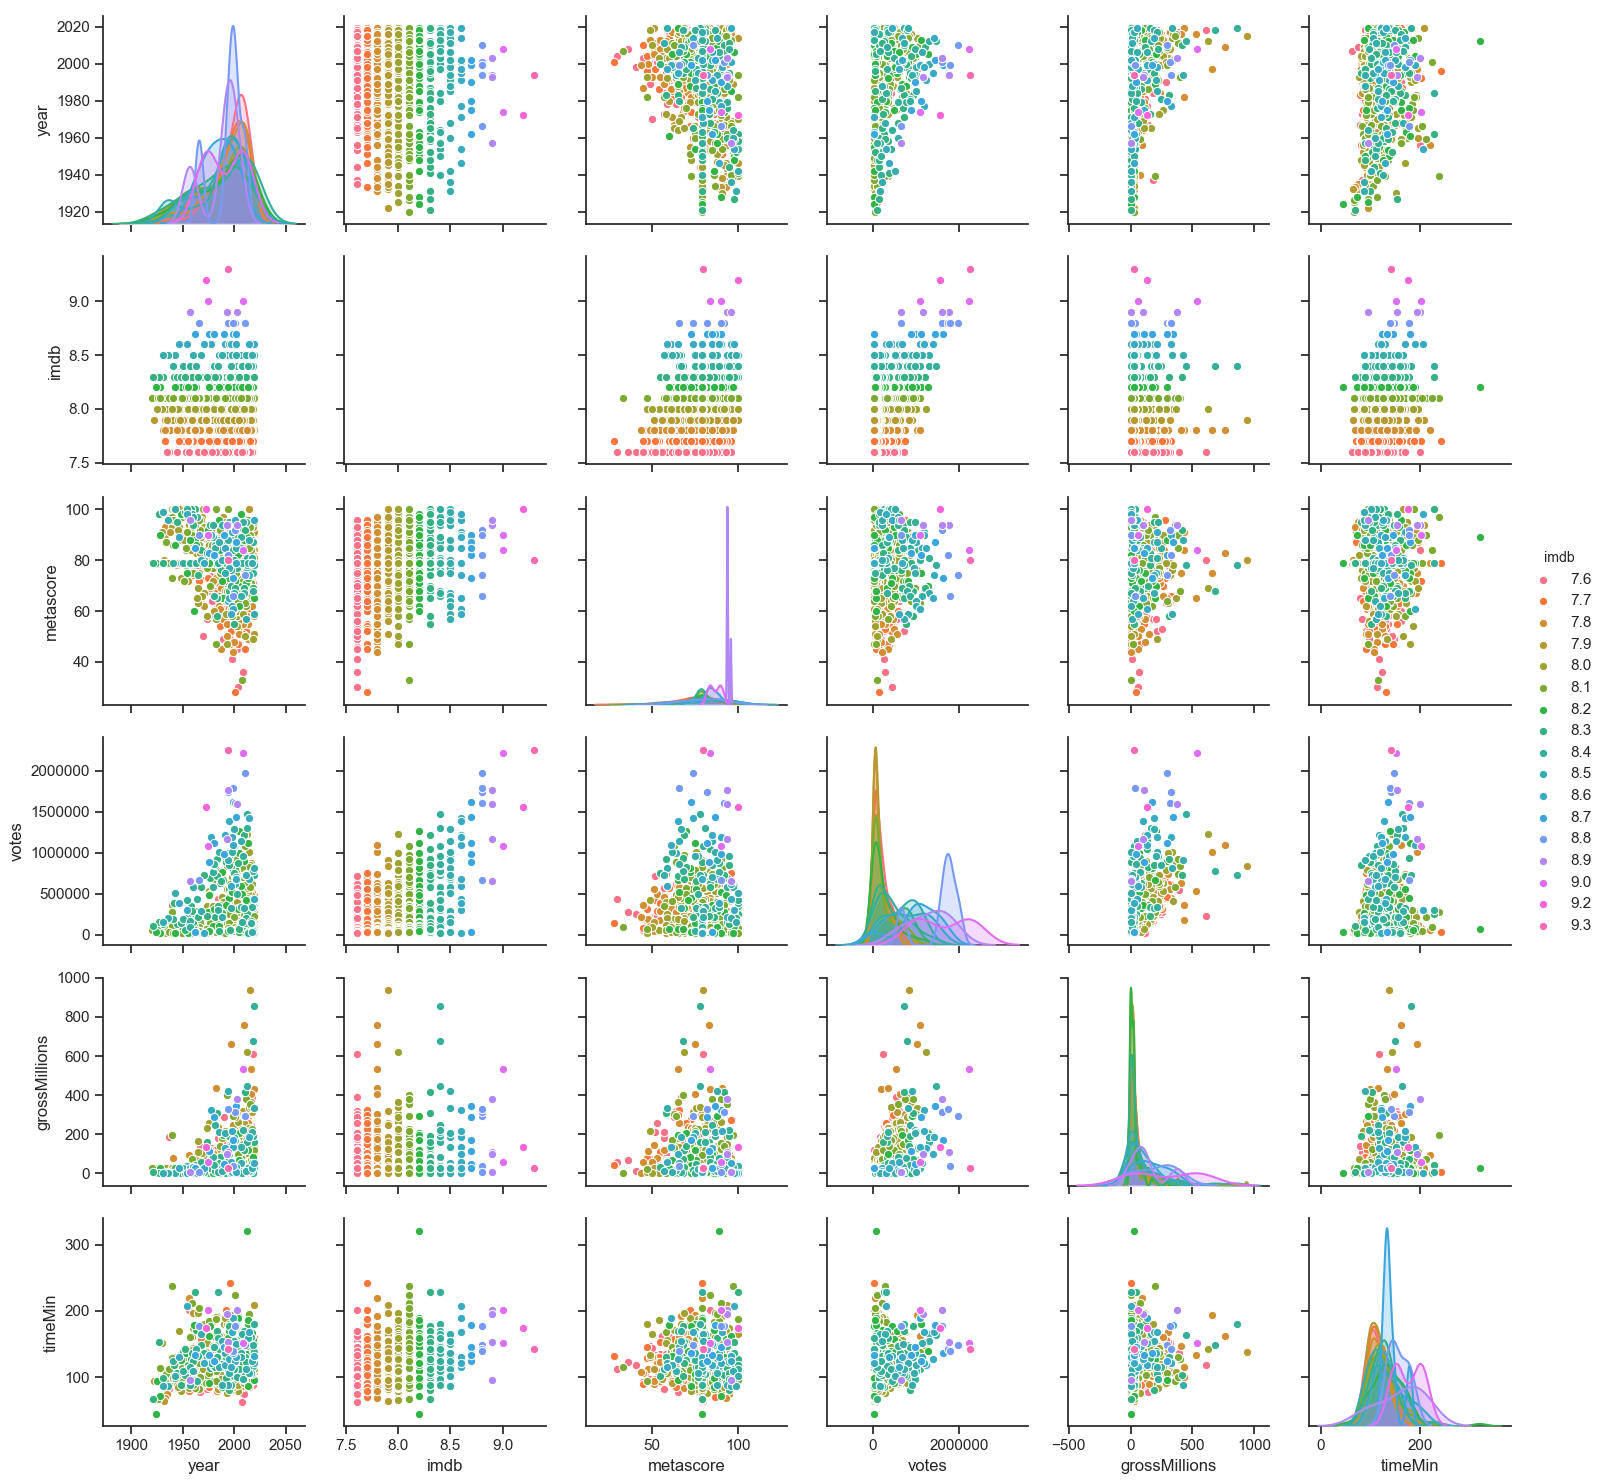

In [179]:
sns.set_style("ticks")
sns.pairplot(movies,hue ="imdb",diag_kind = "kde",kind = "scatter",palette = "husl")
plt.show()

Lets find out the number of movies according to metascore

In [139]:
#Dividing movies into categories with metascore as range filter
df1 = movies.loc[(movies['metascore'] >= 80) & (movies['metascore'] <= 100)]
df2 = movies.loc[(movies['metascore'] >= 60) & (movies['metascore'] <= 80)]
df3 = movies.loc[(movies['metascore'] >= 40) & (movies['metascore'] <= 60)]
df4 = movies.loc[(movies['metascore'] >= 28) & (movies['metascore'] <= 40)] #lowest rating/metascore is 28

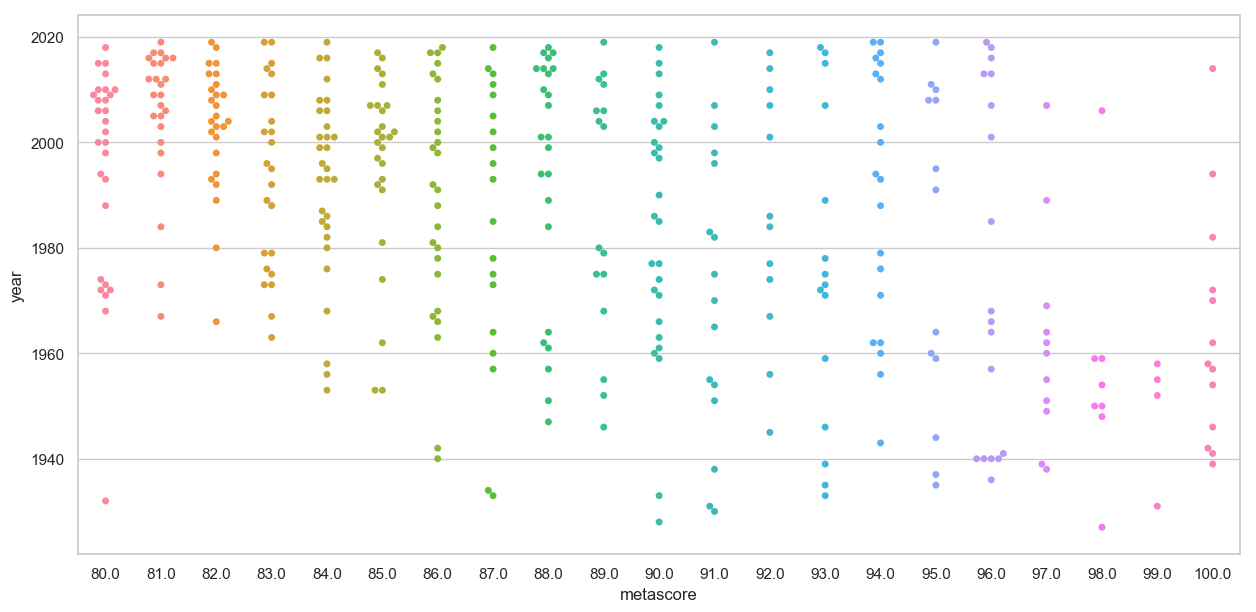

In [168]:
# For 1st category i.e no. of movies have ratings between 80 to 100 year wise
plt.figure(figsize = (15, 7)) 
sns.set(style ="whitegrid") 
ax = sns.swarmplot(x = df1.metascore, y = df1.year , data = df1)
plt.show()

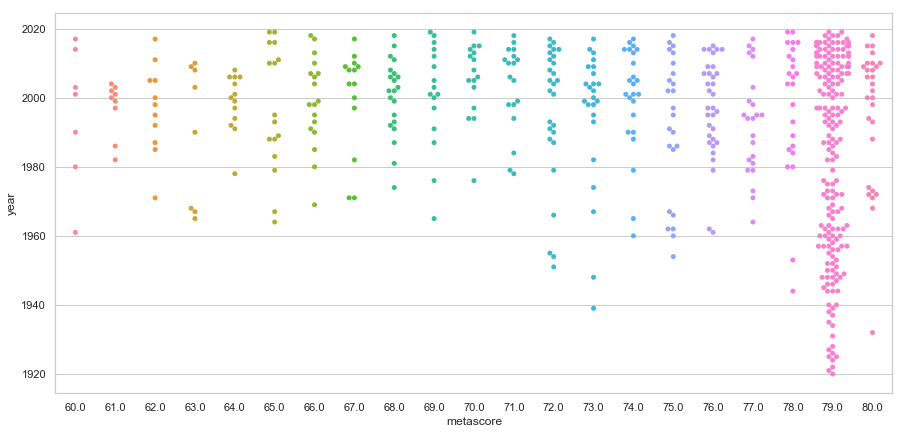

In [161]:
# For 2nd category i.e no. of movies have ratings between 60 to 80 year wise
plt.figure(figsize = (15, 7)) 
sns.set(style ="whitegrid") 
ax = sns.swarmplot(x = df2.metascore, y = df2.year , data = df2)
plt.show()

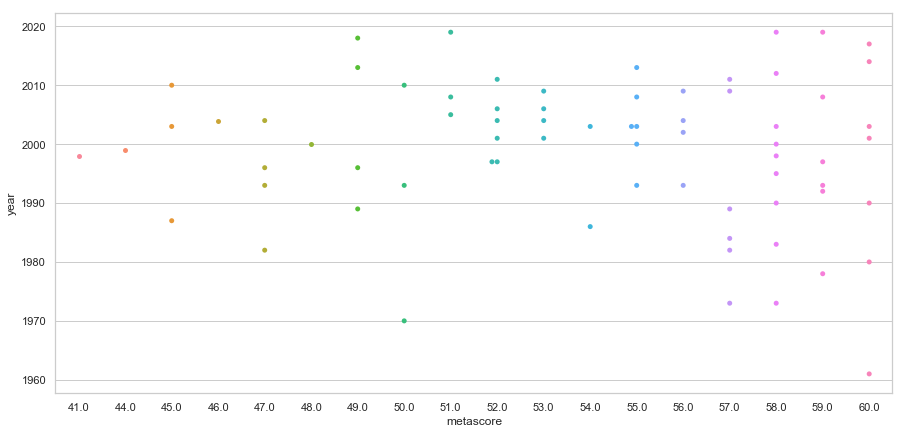

In [162]:
# For 3rd category i.e no. of movies have ratings between 40 to 60 year wise
plt.figure(figsize = (15, 7)) 
sns.set(style ="whitegrid") 
ax = sns.swarmplot(x = df3.metascore, y = df3.year , data = df3)
plt.show()

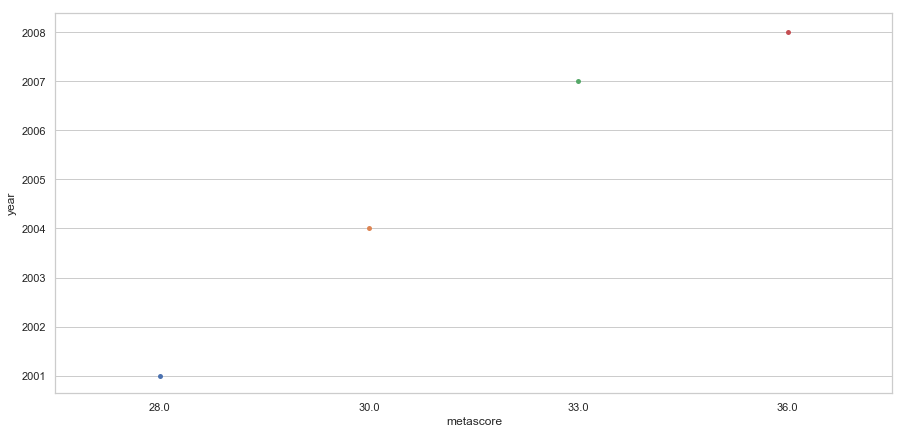

In [163]:
# For 4th category i.e no. of movies have ratings between 28 to 40 year wise
plt.figure(figsize = (15, 7)) 
sns.set(style ="whitegrid") 
ax = sns.swarmplot(x = df4.metascore, y = df4.year , data = df4)
plt.show()

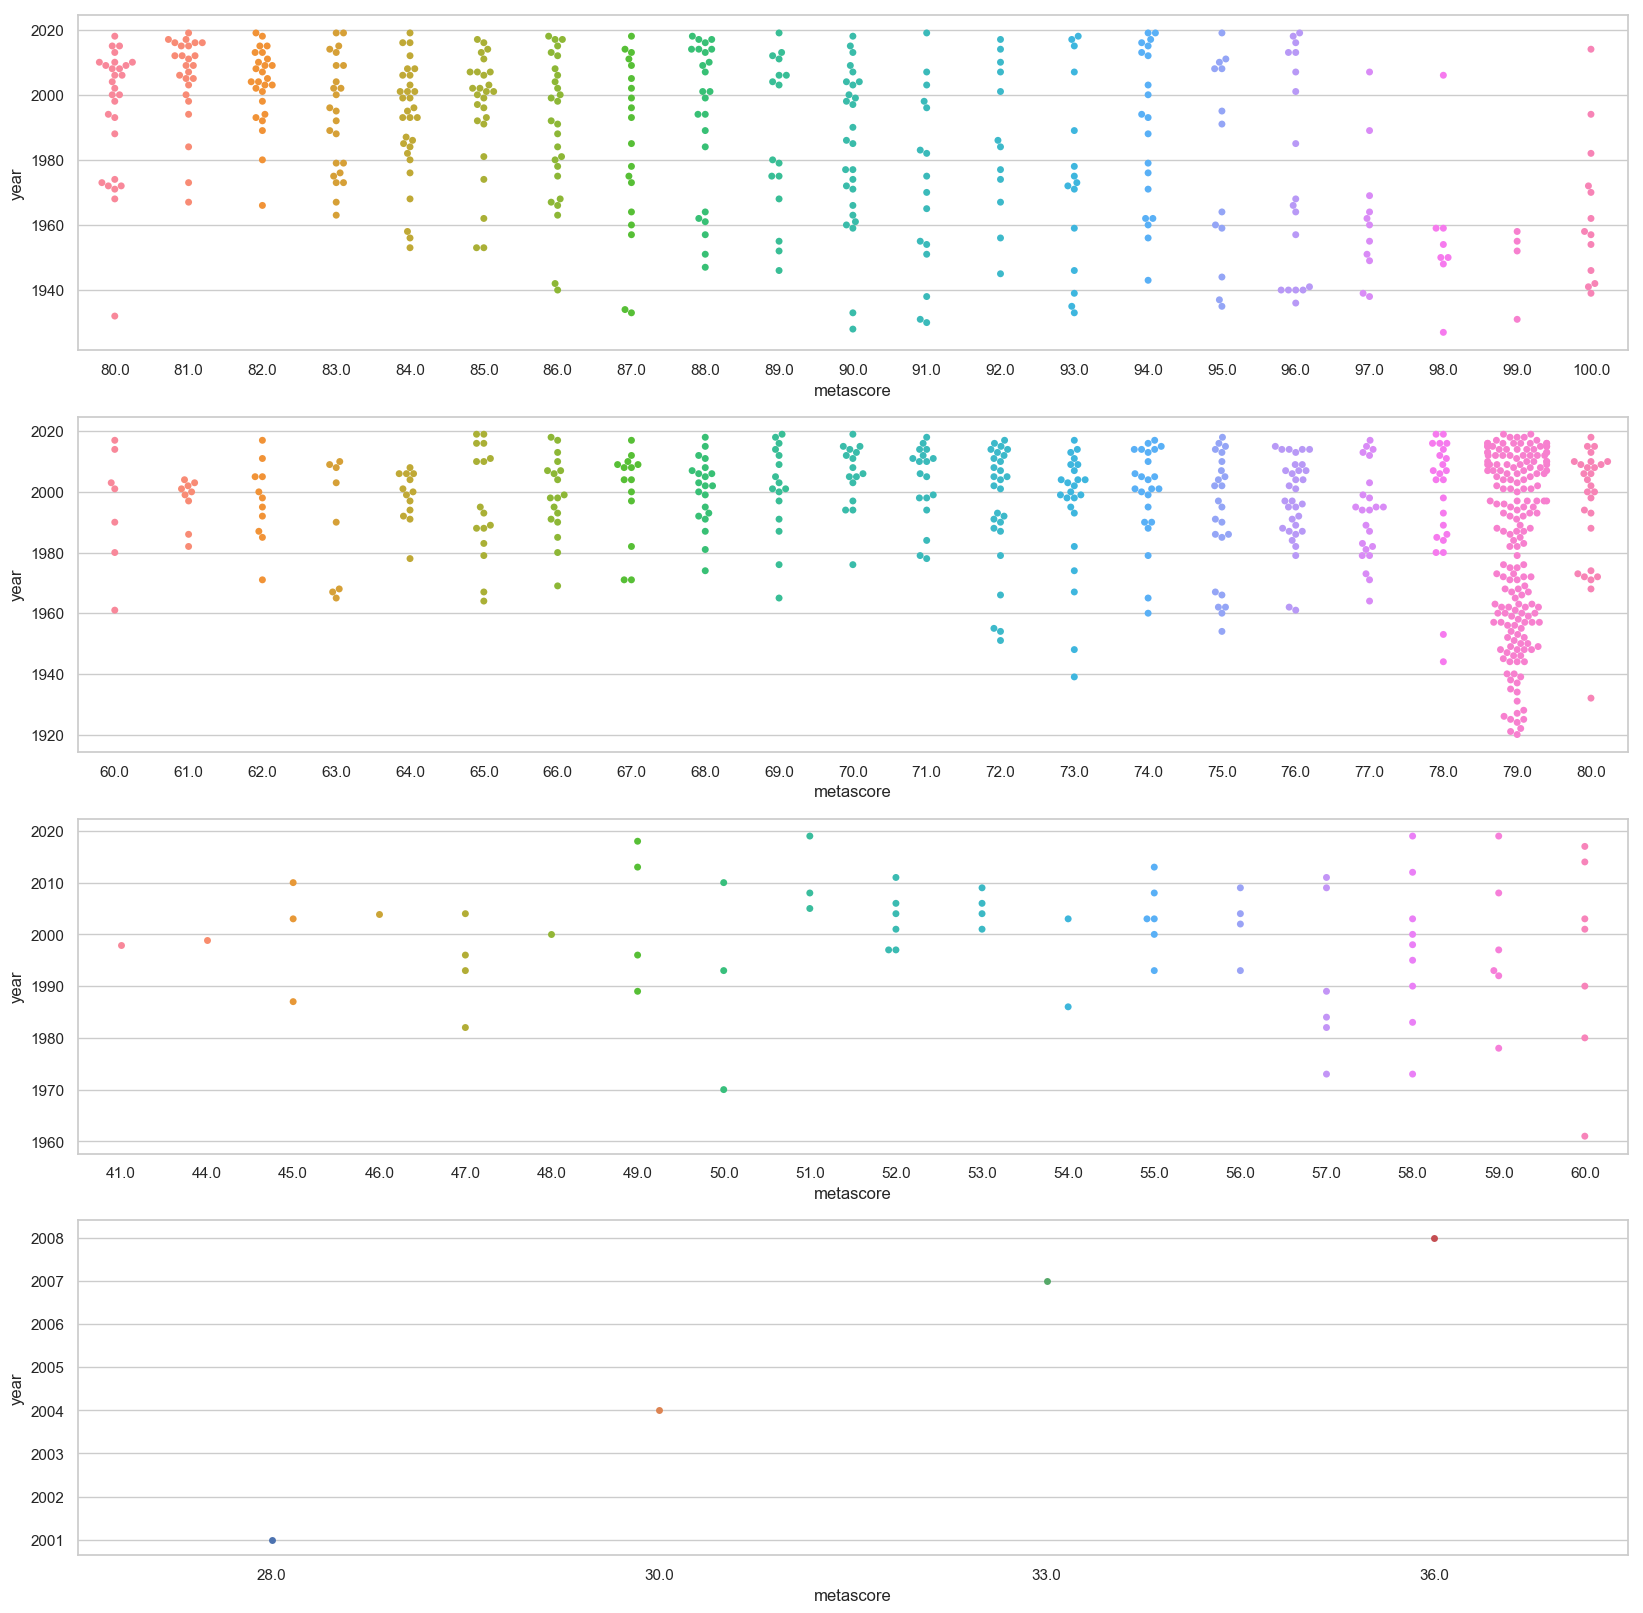

In [173]:
# If we try to put all 4 swarmplot into one single cell
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(20,20)) 
sns.set(style ="whitegrid") 
sns.swarmplot(x = df1.metascore, y = df1.year , data = df1, ax = ax1)

sns.swarmplot(x = df2.metascore, y = df2.year , data = df2, ax = ax2)

sns.swarmplot(x = df3.metascore, y = df3.year , data = df3, ax = ax3)

sns.swarmplot(x = df4.metascore, y = df4.year , data = df4, ax = ax4)

plt.show()

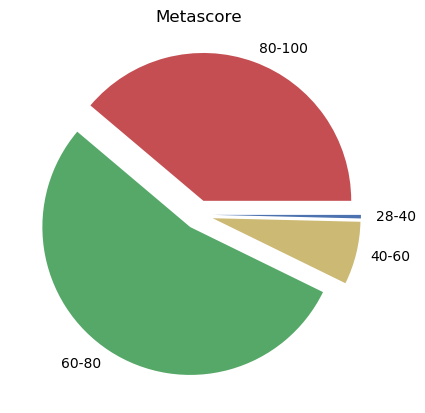

In [181]:
# If we try to findout about the ratio of movies per metascore range, we can use pie chart 
plt.rcdefaults() #Sets the defaults for graph
values = [df1.metascore.count(),df2.metascore.count(),df3.metascore.count(),df4.metascore.count()]
colors = ['r', 'g', 'y', 'b']
labels = ['80-100','60-80','40-60','28-40']
explode = [0.1,0.1,0.1,0.1]
plt.pie(values, colors = colors, labels=labels,explode = explode)
plt.title('Metascore')
plt.show()

Let's find out count of movies per imdb rating

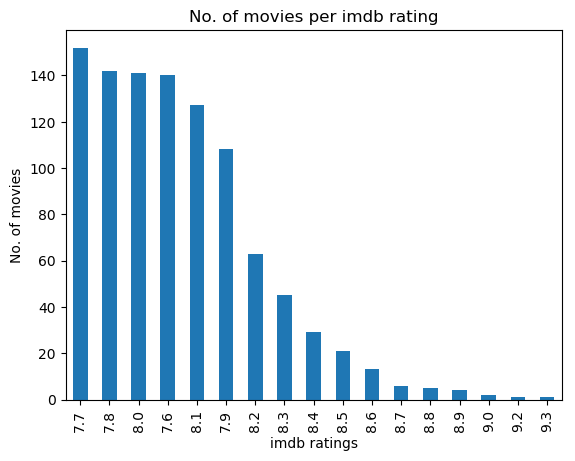

In [202]:
imdb_counts = movies.imdb.value_counts()
#imdb_counts.plot(kind='bar')
#OR
imdb_counts.plot(kind='bar')
plt.title("No. of movies per imdb rating") 
plt.xlabel("imdb ratings") 
plt.ylabel("No. of movies") 
plt.show() 

In [210]:
# To find out the minimum votes given to a movie
movies[movies.votes == movies.votes.min()]

,movie,year,imdb,metascore,votes,grossMillions,timeMin
789,Rififi,1955,8.2,97.0,25256,0.06,118


In [209]:
# To find out the maximum votes given to a movie
movies[movies.votes == movies.votes.max()]

,movie,year,imdb,metascore,votes,grossMillions,timeMin
9,The Shawshank Redemption,1994,9.3,80.0,2257069,28.34,142


In [217]:
# To find out which year holds the maximum no. of movies in top 1000 movie list
movies_per_year = movies.year.value_counts() #provides count in max to min order
movies_per_year

2004    32
2014    31
2009    29
2007    29
2001    27
2016    27
2013    27
2006    27
2015    25
2010    24
2012    24
2003    23
2008    22
1993    22
2019    22
2000    20
2017    20
1995    19
1997    19
2002    19
2005    19
2011    18
1999    17
1998    17
2018    17
1994    14
1962    13
1982    12
1992    12
1989    12
        ..
1958     4
1952     4
1950     4
1981     4
1935     3
1933     3
1938     3
1931     3
1970     3
1949     3
1969     3
1977     3
1942     2
1925     2
1945     2
1947     2
1937     2
1934     2
1941     2
1928     2
1927     2
1921     1
1922     1
1924     1
1932     1
1926     1
1930     1
1936     1
1943     1
1920     1
Name: year, Length: 98, dtype: int64

In [230]:
# To find out which movies earn the lowest
movies[movies.grossMillions == movies.grossMillions.min()]

,movie,year,imdb,metascore,votes,grossMillions,timeMin
435,Mr. Nobody,2009,7.8,63.0,210160,0.0,141
975,Adam's Apples,2005,7.8,51.0,44179,0.0,94
990,Knockin' on Heaven's Door,1997,8.0,79.0,26771,0.0,87


Please note that there are 3 movies in this list, so how we can find out?

As the imdb rating of 2 movies are same, so we cannot use that. That's why i used the metascore feature which has different values for each movie

In [232]:
gm = movies[movies.grossMillions == movies.grossMillions.min()]
gm[gm.metascore == gm.metascore.min()]

,movie,year,imdb,metascore,votes,grossMillions,timeMin
975,Adam's Apples,2005,7.8,51.0,44179,0.0,94


In [227]:
# To find out which movie earned the most
movies[movies.grossMillions == movies.grossMillions.max()]

#P.S:- Haven't the Avengers Endgame beat the star wars in terms of gross value? ;)

,movie,year,imdb,metascore,votes,grossMillions,timeMin
200,Star Wars: Episode VII - The Force Awakens,2015,7.9,80.0,840869,936.66,138
